## Detecting doline alignments

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

### Read and plot

In [2]:
# Load the vectorized depressions
gdf = gpd.read_file('flooded_scalgo.shp')

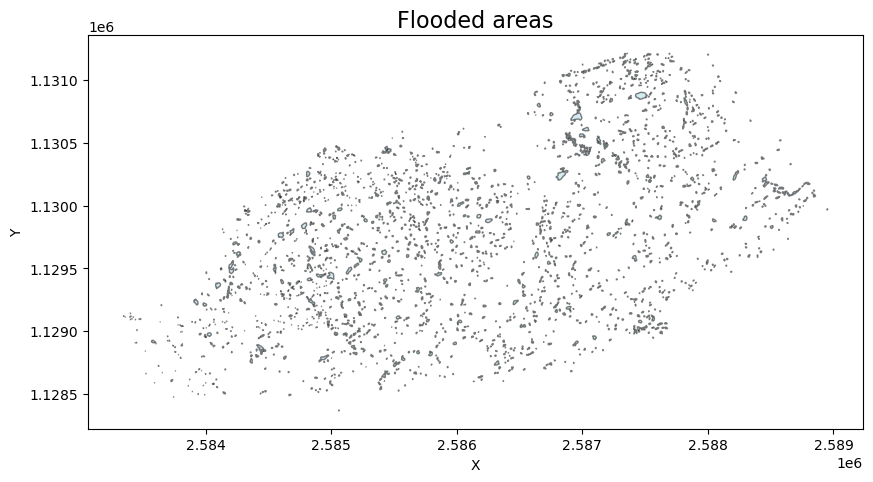

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5, label="Polygons")
ax.set_title('Flooded areas', fontsize=16)
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.savefig("flooded.jpg", dpi=300)

plt.show()

### Post processing data

In [4]:
# Check for invalid geometries
invalid_geometries = gdf[~gdf.geometry.is_valid]
print(f'Number of invalid geometries: {len(invalid_geometries)}')

# Optionally inspect invalid geometries
print(invalid_geometries)

Number of invalid geometries: 1
   FID                                           geometry
0    0  MULTIPOLYGON (((2583342.000 1129120.500, 25833...


In [5]:
# Fix invalid geometries
gdf['geometry'] = gdf.geometry.buffer(0)
print(f'Number of invalid geometries after fixing: {len(gdf[~gdf.geometry.is_valid])}')

Number of invalid geometries after fixing: 0


In [6]:
# Remove small geometries
#min_area_threshold = 10
#gdf = gdf[gdf.geometry.area > min_area_threshold]

In [7]:
# Separete multipolygons
def explode_multipolygons(geometry):
    if isinstance(geometry, MultiPolygon):
        return list(geometry.geoms)
    return [geometry]

# Explode all multipolygons into individual polygons
gdf = gdf.explode(index_parts=False).reset_index(drop=True)

In [8]:
# Check if there are enough points
def has_enough_points(geometry):
    if geometry and geometry.geom_type == 'Polygon':
        return len(geometry.exterior.coords) >= 4
    return False

# Filter out polygons with fewer than 4 points
gdf = gdf[gdf.geometry.apply(has_enough_points)]

In [9]:
# Measure axis od the circular/elipsoidal form
def measure_axes(polygon):
    if isinstance(polygon, Polygon):
        mbr = polygon.minimum_rotated_rectangle
        coords = list(mbr.exterior.coords)
        edge_lengths = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i+1]))
                        for i in range(len(coords) - 1)]
        max_axis = max(edge_lengths)
        min_axis = min(edge_lengths)
        return max_axis, min_axis
    return None, None

# Apply to all polygons
gdf['max_axis'], gdf['min_axis'] = zip(*gdf.geometry.apply(measure_axes))

doline_maxax_length = gdf['max_axis']

In [11]:
# Extract and calculate azimuth
def calculate_azimuth(x1, y1, x2, y2):
    angle_rad = np.arctan2(x2 - x1, y2 - y1)
    angle_deg = np.degrees(angle_rad)
    azimuth = angle_deg % 180
    return azimuth


def extract_max_axis_azimuth(polygon):
    if polygon.is_empty or not isinstance(polygon, Polygon):
        return None

    # Get the minimum bounding rectangle (MBR)
    mbr = polygon.minimum_rotated_rectangle
    coords = list(mbr.exterior.coords)

    # Calculate the length of each side of the rectangle
    edge_lengths = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i + 1])) for i in range(len(coords) - 1)]

    # Identify the two longest sides (maximum axis)
    max_index = edge_lengths.index(max(edge_lengths))
    x1, y1 = coords[max_index]
    x2, y2 = coords[(max_index + 1) % len(coords)]

    # Calculate the azimuth of the maximum axis
    return calculate_azimuth(x1, y1, x2, y2)

In [12]:
# Apply the function to calculate the azimuths
gdf['max_axis_azimuth'] = gdf.geometry.apply(extract_max_axis_azimuth)
#gdf.to_file('flooded_with_axes.shp')

In [13]:
# Calculate and store azimuth in radians
gdf['max_axis_azimuth_rad'] = np.deg2rad(gdf['max_axis_azimuth'])

In [16]:
# Calculate mean orienation
def mean_az(azimuth):
    mean_azimuth_rad = st.circmean(azimuth)
    mean_azimuth_deg = round(np.rad2deg(mean_azimuth_rad))
    std = st.circstd(azimuth)
    std_deg = round(np.rad2deg(std))
    
    return (mean_azimuth_deg, std_deg)

mean_azimuth = mean_az(gdf['max_axis_azimuth_rad'])
print(mean_azimuth)

(79, 47)


In [17]:
# Calculate the number of bins using Rice's Rule
def nbins(data):
    n = len(data)
    num_bins = int(np.ceil(2 * n**(1/3)))

    return (num_bins)

num_bins = nbins(gdf['max_axis_azimuth_rad'])
print(num_bins)

26


In [18]:
# Export to .csv
gdf.to_csv('dol_azimuths.csv')

In [19]:
# Weight the distribution according to the normalized length
dolines_norm = doline_maxax_length / np.sum(doline_maxax_length)

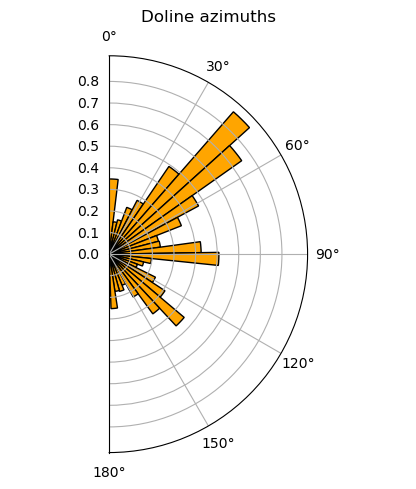

In [20]:
# Plot rose diagram for azimuths
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(polar=True))

ax.hist(gdf['max_axis_azimuth_rad'], bins=num_bins, weights=dolines_norm, color='orange', edgecolor='black', alpha=1, label="Dolines", density=True)
ax.set_title("Doline azimuths")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # Clockwise
ax.set_thetamin(0)   
ax.set_thetamax(180) 

plt.tight_layout()
plt.yticks(np.arange(0, 0.9, 0.1))

#plt.savefig('dolines_azimuths_w.png', dpi=300, transparent=True)

plt.show()

In [21]:
# Compare with fracture and karstic conduit data
frac = pd.read_csv('frac_azimuths.csv') 
karst = pd.read_csv('karst_azimuths.csv')

# Weight the distribution according to the normalized length
frac_length_norm = frac['frac_lengths'] / np.sum(frac['frac_lengths'])
karst_length_norm = karst['karst_lengths'] / np.sum(karst['karst_lengths'])

frac_rad = np.deg2rad(frac['frac_azimuths'])
karst_rad = np.deg2rad(karst['karst_azimuths'])

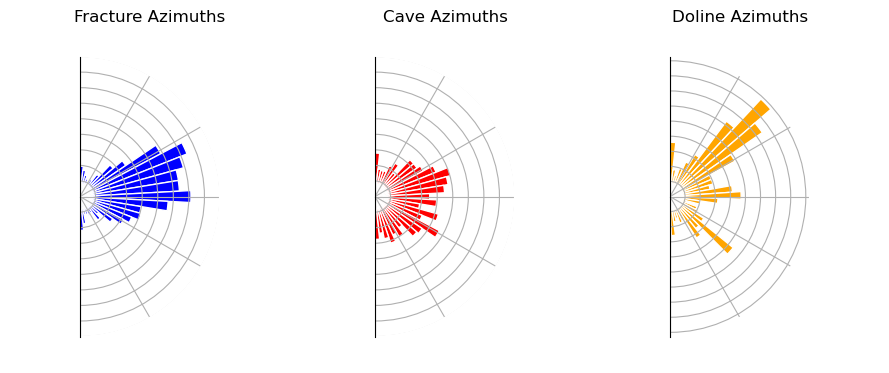

In [22]:
# Plot rose diagrams for fractures and caves with weights
yticks = np.arange(0, 1, 0.1)
fig, ax = plt.subplots(1, 3, figsize=(9, 5), subplot_kw=dict(polar=True))

for a in ax:
    a.spines['polar'].set_color('white')        
    a.spines['polar'].set_linewidth(1.5)

    # Set the tick parameters manually
    a.tick_params(colors='white')               
    a.yaxis.label.set_color('white')     
    a.xaxis.label.set_color('white') 
    
# Fractures
ax[0].hist(frac_rad, bins=29, weights=frac_length_norm, color='blue', edgecolor='white', alpha=1, density=True)
ax[0].set_title("Fracture Azimuths")
ax[0].set_theta_zero_location('N')
ax[0].set_theta_direction(-1)
ax[0].set_thetamin(0)
ax[0].set_thetamax(180)
ax[0].set_yticks(yticks)
#ax[0].grid(color='white')

# Caves
ax[1].hist(karst_rad, bins=29, weights=karst_length_norm, color='red', edgecolor='white', alpha=1, density=True)
ax[1].set_title("Cave Azimuths")
ax[1].set_theta_zero_location('N')
ax[1].set_theta_direction(-1)
ax[1].set_thetamin(0)
ax[1].set_thetamax(180)
ax[1].set_yticks(yticks)
#ax[1].grid(color='white')

# Dolines
ax[2].hist(gdf['max_axis_azimuth_rad'], bins=29, weights=dolines_norm, color='orange', edgecolor='white', alpha=1, density=True)
ax[2].set_title("Doline Azimuths")
ax[2].set_theta_zero_location('N')
ax[2].set_theta_direction(-1)
ax[2].set_thetamin(0)
ax[2].set_thetamax(180)
ax[2].set_yticks(yticks)
#ax[2].grid(color='white')

plt.tight_layout()
#plt.savefig('roses_all.png', dpi=300, transparent=True)

plt.show()

## Aplying the Hough Transform to detect alignments among dolines

Algo by Surya Teja Karri (https://medium.com/@st1739/hough-transform-287b2dac0c70)

Hough transform is a feature extraction method used in image analysis. We apply it to detect straight lines in an image of dolines.
Torm the image sis transformed pace into hough space. By doing vert a line in image sis converted pace to a point on hough s
The equation of the line in the image space is of the form y = mx + c where m is the slope and c is the y-intercept of the line. This line will be transformed to a point of the form (m, c) in the hough space.

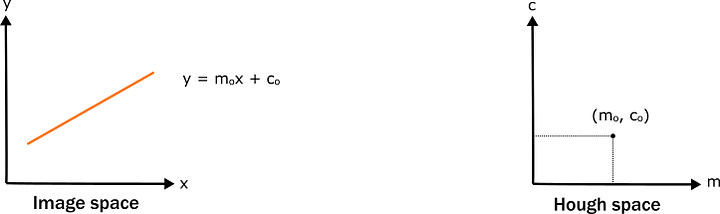

To find the continous line in an image, in this case a doline alignment, we transform a dicontinous line in image space to hough space and look for intersection points in hough space. This intersection point in hough space will represent the continous line in image space.

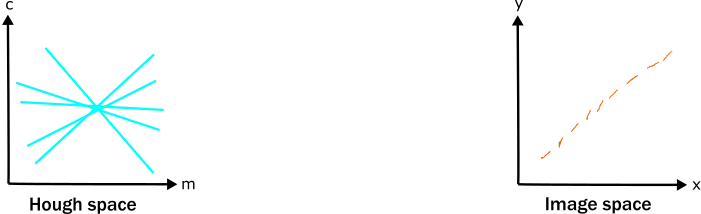pace.

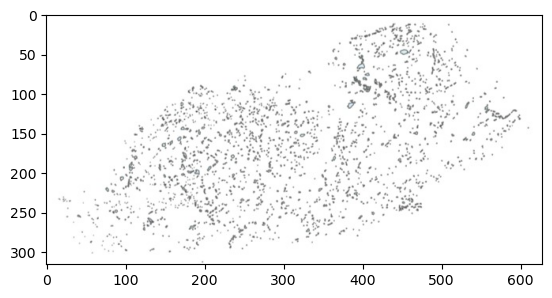

In [24]:
# Use cv2 for image processing
import cv2

# Read image
image = cv2.imread('flooded_hough.jpg')

# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

plt.savefig('flooded_h0.jpg', dpi=300)

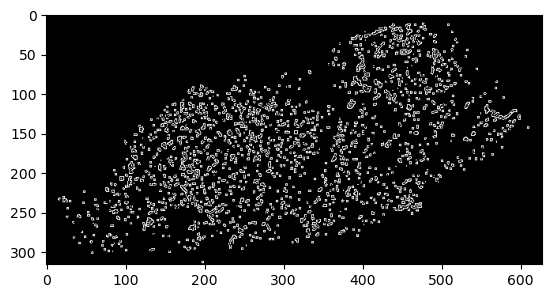

In [25]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define our parameters for Canny edge detection
low_threshold = 50
high_threshold = 100
edges = cv2.Canny(gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

plt.savefig('flooded_h1.jpg', dpi=300)

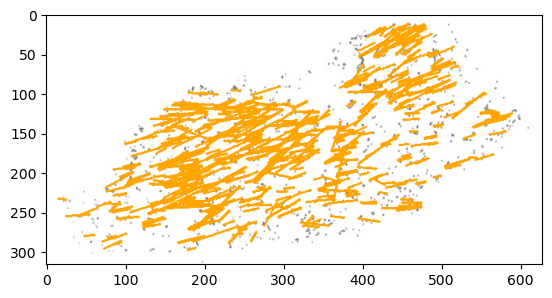

In [70]:
# Define the Hough transform parameters
rho = 1
theta = np.pi/180
threshold = 50
min_line_length = 10
max_line_gap = 10
line_image = np.copy(image)

# Run Hough on the edge-detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the image copy
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0, 165, 270),2)
        
# Convert color
line_image_rgb = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image_rgb)

plt.savefig('flooded_h2.png', dpi=300)

In [71]:
# Compute angle in radians (in image coordinates)
dol_hough_rad = []
dol_hough_az = []
len_lines = []

for line in lines:
    for x1,y1,x2,y2 in line:
        dx = x2 - x1
        dy = y2 - y1

        theta_rad = np.arctan2(dx, dy)
        theta_deg = (np.degrees(theta_rad))
        azimuth_h = -theta_deg % 180
        dol_hough_az.append(azimuth_h)
        dol_hough_rad = np.deg2rad(dol_hough_az)
     
        dz = (dy**2)+(dx**2)
        len_line = np.sqrt(dz)
        len_lines.append(len_line)

In [72]:
# Weight the distribution according to the normalized length
dolh_norm = len_lines / np.sum(len_lines)

In [73]:
num_bins = nbins(dol_hough_rad)
print(num_bins)

17


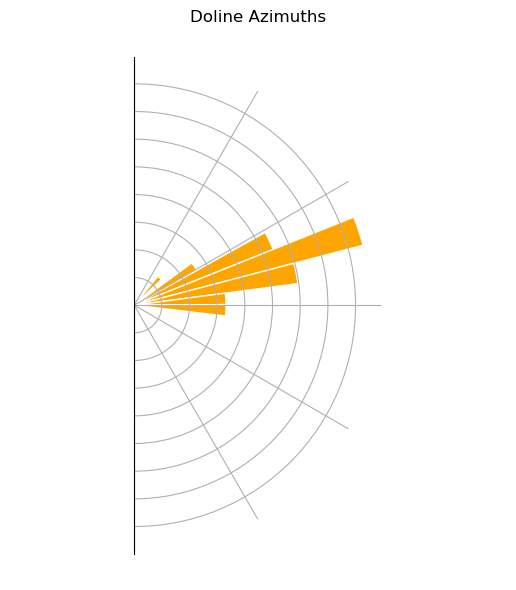

In [74]:
# Plot rose for dolines
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
plt.hist(dol_hough_rad, bins=15, color='orange', edgecolor='white', alpha=1, density=True)
ax.set_title("Doline Azimuths")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetamin(0)
ax.set_thetamax(180)

ax.spines['polar'].set_color('white')
ax.spines['polar'].set_linewidth(1.5)

ax.tick_params(colors='white')              
ax.yaxis.label.set_color('white')           
ax.xaxis.label.set_color('white') 

#yticks = np.arange(0, 1, 0.1)
#ax.set_yticks(yticks)

#ax.grid(color='white')

plt.tight_layout()
plt.savefig('dol_hough.png', dpi=300, transparent=True)

plt.show()

In [75]:
mean_azimuth = mean_az(dol_hough_rad)
print(mean_azimuth)

(73, 13)


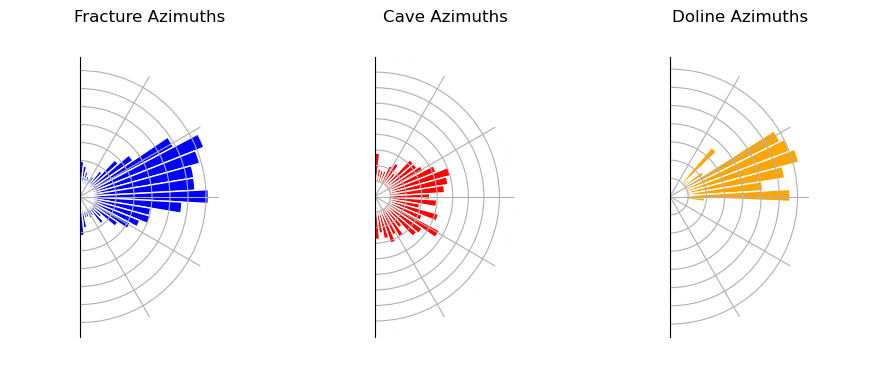

In [32]:
# Plot rose diagrams for fractures and caves with weights
yticks = np.arange(0, 1, 0.1)
fig, ax = plt.subplots(1, 3, figsize=(9, 5), subplot_kw=dict(polar=True))

for a in ax:
    a.spines['polar'].set_color('white')        # Set the border color
    a.spines['polar'].set_linewidth(1.5)

    # Set the tick parameters manually
    a.tick_params(colors='white')               # Changes color of tick marks and labels
    a.yaxis.label.set_color('white')            # Radial label color
    a.xaxis.label.set_color('white') 
    
# Fractures
ax[0].hist(frac_rad, bins=29, weights=frac_length_norm, color='blue', edgecolor='white', alpha=1, density=True)
ax[0].set_title("Fracture Azimuths")
ax[0].set_theta_zero_location('N')
ax[0].set_theta_direction(-1)
ax[0].set_thetamin(0)
ax[0].set_thetamax(180)
#ax[0].set_yticks(yticks)
#ax[0].grid(color='white')

# Caves
ax[1].hist(karst_rad, bins=29, weights=karst_length_norm, color='red', edgecolor='white', alpha=1, density=True)
ax[1].set_title("Cave Azimuths")
ax[1].set_theta_zero_location('N')
ax[1].set_theta_direction(-1)
ax[1].set_thetamin(0)
ax[1].set_thetamax(180)
ax[1].set_yticks(yticks)
#ax[1].grid(color='white')

# Dolines
ax[2].hist(dol_hough_rad, bins=16, weights=dolh_norm, color='orange', edgecolor='white', alpha=1, density=True)
ax[2].set_title("Doline Azimuths")
ax[2].set_theta_zero_location('N')
ax[2].set_theta_direction(-1)
ax[2].set_thetamin(0)
ax[2].set_thetamax(180)
#ax[2].set_yticks(yticks)
#ax[2].grid(color='white')

plt.tight_layout()
plt.savefig('roses_all_dolh.png', dpi=300, transparent=True)

plt.show()

In [34]:
# Test the hypothesis that the azimuths are similar from the fractures and karst
frac_hist, bin_edges = np.histogram(frac_rad, bins=15, weights=frac_length_norm)
dol_hist, _ = np.histogram(dol_hough_rad, bins=15, weights=dolh_norm)

#Constructing the contingency table
contingency_table = np.array([frac_hist, dol_hist])

# Calculating the expected frequencies
expected_frequencies = contingency_table.mean(axis=0)

# Adjust expected frequencies so their sum matches the observed frequency total
expected_frequencies *= frac_hist.sum() / expected_frequencies.sum()

# Perform the chi-squared test on the contingency table
chi2_stat, p_value = st.chisquare(f_obs=frac_hist, f_exp=expected_frequencies)

#print("Contingency table:")
#print("bins:", bin_edges)
#print("Fracture counts:", frac_hist)
#print("Karst counts:", karst_hist)
print(f"Chi-Squared Statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: the azimuth distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: no significant difference in azimuth distributions.")

Chi-Squared Statistic: 0.17
p-value: 1.000
Fail to reject the null hypothesis: no significant difference in azimuth distributions.


In [35]:
# Test the hypothesis that the azimuths are similar from the fractures and karst
karst_hist, bin_edges = np.histogram(karst_rad, bins=20, weights=karst_length_norm)
dol_hist, _ = np.histogram(dol_hough_rad, bins=20, weights=dolh_norm)

#Constructing the contingency table
contingency_table = np.array([karst_hist, dol_hist])

# Calculating the expected frequencies
expected_frequencies = contingency_table.mean(axis=0)

# Adjust expected frequencies so their sum matches the observed frequency total
expected_frequencies *= frac_hist.sum() / expected_frequencies.sum()

# Perform the chi-squared test on the contingency table
chi2_stat, p_value = st.chisquare(f_obs=karst_hist, f_exp=expected_frequencies)

#print("Contingency table:")
#print("bins:", bin_edges)
#print("Fracture counts:", frac_hist)
#print("Karst counts:", karst_hist)
print(f"Chi-Squared Statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: the azimuth distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: no significant difference in azimuth distributions.")

Chi-Squared Statistic: 0.21
p-value: 1.000
Fail to reject the null hypothesis: no significant difference in azimuth distributions.


In [ ]:
#fazer com entradas de cavernas